### Exercise 3: Classification of Airline Tweets with Pretrained Transformers

##### Import the libraries necessary for this project.

In [1]:
import numpy as np
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
import transformers
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

##### Data Preprocessing: Loading the dataset and preprocessing steps as in Exercise 1.

In [2]:
def remove_unwanted(text):
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    emojis = re.compile(
        "[\U0001F600-\U0001F64F" # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "\U0001F700-\U0001F77F"  # Alchemical Symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"  # Enclosed characters
        "]", flags=re.UNICODE
    )
    text = emojis.sub(r'', text)
    return text

def preprocessing(sentence):
    sentence = remove_unwanted(sentence)
    sentence = sentence.lower()
    tokens = word_tokenize(sentence, language='english', preserve_line=True)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    text = " ".join(filtered_tokens)
    return filtered_tokens

In [3]:
df = pd.read_csv("datasets/Tweets.csv", encoding="utf-8")
tokens = [preprocessing(sentence) for sentence in df['text']]
df['text'] = [" ".join(token) for token in tokens]

labels = df.airline_sentiment.unique()
print(f'The labels of the dataset are: {labels}')

The labels of the dataset are: ['neutral' 'positive' 'negative']


##### The following code snippet provided in the course materials (Useful Code of the Lesson). Hyperparameters and architecture adjusted to improve performance and achieve the best results.

In [4]:
X = [str(i) for i in df["text"].values]
y = [str(i) for i in df["airline_sentiment"].values]

# Create a train/test split
# Adjust test_size and random_state as you prefer
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,       # 20% of data goes to test
    random_state=42,     # for reproducibility
    stratify=y           # keeps class distribution balanced
)

# For example, take 10% of the original training data to form a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.1,
    random_state=42,
    stratify=y_train
)

# Convert your list of lists of labels into a binarized form
mlb = MultiLabelBinarizer()
y_train_encoded = mlb.fit_transform(y_train)
y_val_encoded = mlb.transform(y_val)
y_test_encoded = mlb.transform(y_test)

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_val_vectorized = vectorizer.transform(X_val)

# Use OneVsRestClassifier for multi-label classification
model = OneVsRestClassifier(LogisticRegression(max_iter=1000))
model.fit(X_train_vectorized, y_train_encoded)

# Predict on the training set
y_train_pred = model.predict(X_train_vectorized)

# Predict on the validation set
y_val_pred = model.predict(X_val_vectorized)

# Instantiate the BERT tokenizer with WordPiece tokenization
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function for the tokenization
def tokenize_text(data, tokenizer, max_length=256):
    return tokenizer(data, padding='max_length',
                     max_length=max_length, truncation=True, return_tensors='pt')

bert_val = tokenize_text(X_val, bert_tokenizer)
bert_train = tokenize_text(X_train, bert_tokenizer)
bert_test = tokenize_text(X_test, bert_tokenizer)

# Load BERT model and tokenizer
model_name = 'bert-base-uncased'
bert_model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(labels))

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
print(f"Using device: {device}")

# Move your model to the selected device
bert_model = bert_model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


In [5]:
# Make y_train, y_dev tensors
y_train_encoded = torch.tensor(y_train_encoded)
y_val_encoded = torch.tensor(y_val_encoded)

# Define batch size
batch_size = 16

# Create TensorDatasets
train_dataset = TensorDataset(bert_train['input_ids'], bert_train['attention_mask'], y_train_encoded)
val_dataset = TensorDataset(bert_val['input_ids'], bert_val['attention_mask'], y_val_encoded)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

param_freeze = ['bert.embeddings', 'bert.encoder.layer.0',
                'bert.encoder.layer.1.', 'bert.encoder.layer.2',
                'bert.encoder.layer.3', 'bert.encoder.layer.4',
                'bert.encoder.layer.5']

# Unfreeze the parameters of the classification head except the above
for name, param in bert_model.named_parameters():
    param.requires_grad = not any(name.startswith(prefix) for prefix in param_freeze)

In [6]:
from IPython.display import display, update_display
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define the number of epochs
num_epochs = 20

#optimizer_grouped_parameters = [
#    {'params': bert_model.bert.encoder.layer[i].parameters(), 'lr': 1e-5 / (i + 1)}
#    for i in range(len(bert_model.bert.encoder.layer))
#]
#optimizer = Adam(optimizer_grouped_parameters, lr=1e-5)
# Prepare optimizer and loss function
optimizer = Adam(bert_model.parameters(), lr=1e-5)

# Set up the ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Updated loss function with weights
loss_function = torch.nn.BCEWithLogitsLoss()

# Initialize a display object for updating output in-place
display_id = 'batch_update'
display_obj = display("", display_id=display_id)

# Initialize lists to store history
train_losses = []
val_losses = []
patience = 0

# Initialize variables to track best validation loss and corresponding model weights
best_val_loss = float('inf')
best_model_weights = None

# Adjust the model's output layer, if not already adjusted
bert_model.classifier = torch.nn.Linear(bert_model.config.hidden_size, len(mlb.classes_))
bert_model.to(device)

# Training loop
for epoch in range(num_epochs):
    # Unfreeze each layer progressively
    #for layer in bert_model.bert.encoder.layer:
    #    for param in layer.parameters():
    #        param.requires_grad = True
    #        bert_model.train()
    bert_model.train()
    total_loss = 0
    cnt = 0
    for batch in train_loader:
        cnt += 1
        optimizer.zero_grad()  # Reset gradients to zero for each batch
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)  # Move the tensors to the specified device
        # Get model outputs (logits)
        outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        
        logits = outputs.logits  # Ensure your model configuration aligns with this, or adjust as needed
        
        # Compute loss using the logits from the model and the labels from your dataset
        loss = loss_function(logits, labels.float())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        # Update the displayed output for this batch
        output = f'For batch "{cnt}": Training - Loss: {total_loss/cnt:.3f}'
        update_display(output, display_id=display_id)
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'\nEpoch {epoch+1}/{num_epochs}: Training - Loss: {avg_train_loss:.3f}')

    # Validation loop
    bert_model.eval()
    total_val_loss = 0
    for batch in val_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)  # Move the tensors to the specified device
        with torch.no_grad():
            outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            val_loss = loss_function(logits, labels.float())

        total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_weights = bert_model.state_dict()
        torch.save(best_model_weights, 'datasets/best_model.pth')  # Make sure the path is correct and accessible
        print(f'Validation improved, saving model to /content/drive/MyDrive/best_model.pth')
        patience = 0
    else:
        print(f'Validation did not improve')
        patience += 1
        if patience >= 5:
            print('Early stopping')
            break

    print(f'Validation - Loss: {avg_val_loss:.3f}')
    
    # Check the average validation loss and update the learning rate accordingly
    scheduler.step(avg_val_loss)

'For batch "659": Training - Loss: 0.112'


Epoch 1/20: Training - Loss: 0.370
Validation improved, saving model to /content/drive/MyDrive/best_model.pth
Validation - Loss: 0.282

Epoch 2/20: Training - Loss: 0.256
Validation improved, saving model to /content/drive/MyDrive/best_model.pth
Validation - Loss: 0.261

Epoch 3/20: Training - Loss: 0.224
Validation improved, saving model to /content/drive/MyDrive/best_model.pth
Validation - Loss: 0.257

Epoch 4/20: Training - Loss: 0.197
Validation did not improve
Validation - Loss: 0.258

Epoch 5/20: Training - Loss: 0.180
Validation did not improve
Validation - Loss: 0.261

Epoch 6/20: Training - Loss: 0.157
Validation did not improve
Validation - Loss: 0.264

Epoch 7/20: Training - Loss: 0.138
Validation did not improve
Validation - Loss: 0.285

Epoch 8/20: Training - Loss: 0.112
Validation did not improve
Early stopping


##### Plot training and validation losses.

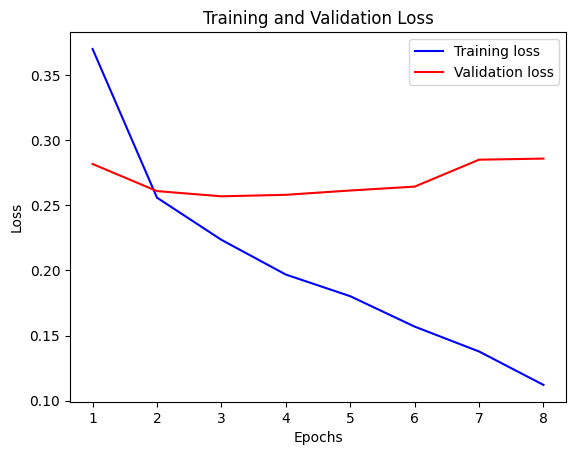

In [7]:
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

##### Evaluation on training data.

In [37]:
bert_model.eval()
predictions_test = []
true_labels_test = []

for batch in train_loader:
    input_ids, attention_mask, labels = batch
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

    with torch.no_grad():
        outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Apply sigmoid to the logits and then threshold to get binary predictions
    predictions = torch.sigmoid(logits).cpu().numpy() > 0.3
    labels = labels.cpu().numpy()

    # Extend the lists with the batch predictions and true labels
    predictions_test.extend(predictions)
    true_labels_test.extend(labels)

# At this point, you have the true labels and predictions
# You can then flatten these lists and use them in sklearn's classification_report
true_labels_test = np.array(true_labels_test)
predictions_test = np.array(predictions_test)

##### Create function for plotting confusion matrix.

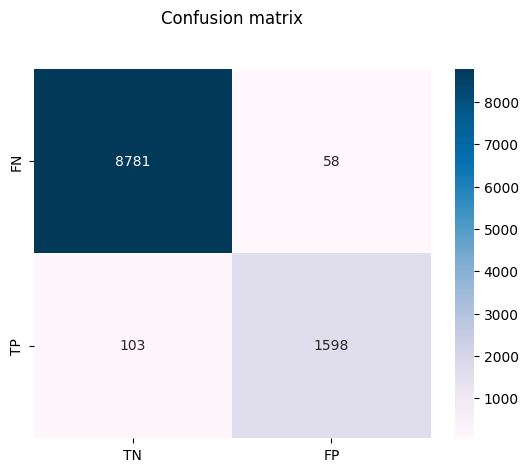

In [43]:
def plot_cm(cm):
  sns.heatmap(pd.DataFrame(cm), annot=True, cmap="PuBu" ,fmt='g', xticklabels=['Positive','Negative'], yticklabels=['Positive','Negative'])
  plt.title('Confusion matrix', y=1.1)
  plt.show()

cm = confusion_matrix(true_labels_test.argmax(axis=1), predictions_test.argmax(axis=1))
plot_cm(cm)

#### Brief Explanation
##### Transformer Model Architecture
For the classification of airline tweets, we chose the BERT (Bidirectional Encoder Representations from Transformers) model. BERT is a transformer-based model that uses a bidirectional approach to pre-train language representations. It is designed to understand the context of a word based on its surroundings both before and after the word, which is achieved through its bidirectional training method. The BERT model consists of multiple layers of encoders, each with self-attention mechanisms, allowing it to capture intricate patterns in the text.

Fine-tuning is the process of adapting the pretrained transformer model to the specific task of classifying airline tweets allowing it to improve its performance.

##### Model Modifications Experiments
1. **Freezing Layers**: We froze the initial layers of the BERT model that contain general knowledgeand focus on fine-tuning the layers for the specific classification task.
2. **Gradual Unfreezing**: Gradually unfreeze the layers of the Transformer model during training helps in retaining the learned features in the early layers while fine-tuning the higher layers.
3. **Adjusting Learning Rates**: Assign higher learning rates to the top layers and lower learning rates to the bottom layers helped in achieving better performance. This technique, known as layer-wise learning rate decay, ensures that the top layers adapt faster to the specific task.
   
By implementing these modifications, we were able to enhance the performance of the BERT model for the task of airline tweet classification, ensuring accurate and efficient sentiment analysis.